Computational Wave Flume (2D Version)
==============================

This notebook provides a numerical model of a wave tank that would look something like this schematically:

![flume](flume_schematic.png)

Mathematical Model
===============

To model a tank with breaking and overtopping, we solve the following air/water flow equations in 2D (a vertical slice):

$$
\begin{eqnarray}
\nabla \cdot \left( \epsilon \mathbf v \right) &=& s \\
\frac{\partial \left( \epsilon \mathbf v \right)}{\partial t} +\nabla \cdot  \left(\epsilon \mathbf v \otimes \mathbf v\right) -  \nabla \cdot \left\{\epsilon \nu_t \left(\nabla  \mathbf v+\nabla \mathbf v^T\right) \right\} + \mathbf r + \frac{\epsilon \nabla p}{\rho} &=& 0 \\
\frac{\partial \phi}{\partial t} + \mathbf v \cdot \nabla \phi &=& 0 \\
\|\nabla \phi\| &=& 1 \\
\frac{\partial \theta}{\partial t} + \nabla \cdot \left( \theta \epsilon \mathbf v \right) &=& 0 \\
H(\phi) &=& \theta 
\end{eqnarray}
$$

Notes about this demo
================

- This software can be run locally on mac, windows, and linux if the Proteus stack is installed.
- It can also be accessed from a cloud service like JupyterHub, Sage Math Cloud, Wakari, or an internal cloud server if we invest in setting one up (you are probably viewing on try.proteustoolkit.org)
- This particular notebook can also be saved as a Python script and run on HPC machines if they have the Proteus software stack installed
- Grid generation, specification of input parameters like waves, boundary conditions, and material properties can all be viewed, set from pre-existing definitions, or redefined in this notebook.
- The simulation is kicked off in the notebook as a seperate thread and monitored
- The data is archived  in XDMF, which can be opened upon completion of the simulation for post-processing, furthermore additional simulations and multiple scripted runs can be orchestrated by modifying this notebook.



Parallelism 
=========

- We need to use multiple processors to compute the solution efficiently in 3D and sometimes even in 2D. 
- The IPython parallel (ipyparallel) infrastructure allows us to attach to a set of "engines" (e.g. MPI tasks on an HPC machine) 

In [2]:
from ipyparallel import Client, error
import os
cluster = Client(profile='mpi')
view = cluster[:]
view.apply(os.chdir, os.getcwd())
print view

<DirectView [0, 1, 2, 3]>


IPython Parallel "Magics"
====================

As a first example of executing code in parallel on our, we use the cell magic `%%px` to execute some basic MPI code on every engine in our cluster. 


In [4]:
%%px
from mpi4py import MPI
mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 3/4
[stdout:1] MPI rank: 0/4
[stdout:2] MPI rank: 2/4
[stdout:3] MPI rank: 1/4


Load Proteus
==========

Proteus is a Python package consiting of multiple modules. We are going to define a problem and run a simulation interactively, so we pull in the iproteus (interactive proteus) module to set up a basic environment.

Notes:
---------

- Proteus runs with logging that records verying amounts of information by setting logLevel from 1 to 11
- The log is stored  in a .log file, which can be downloaded
- If Profiling.verbose is set  to True then logging will show up in certain output cells of the notebook, which is usually not what you want

In [5]:
%%px
import sys
import proteus
# Required imports
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so
Profiling.logLevel=5
Profiling.verbose=False

Define the flume geometry
=========================

We will just import a predefined geometry from `tank.py`


In [7]:
%%px
import tank

In [8]:
%matplotlib notebook
from helpers import *

In [9]:
%%px
print tank.domain.vertices
#tank.domain.vertices[1]=[0.222,0.0]
#tank.domain.vertices[2]=[0.292,0.2]
#tank.domain.vertices[3]=[0.316,0.2]
#tank.domain.vertices[4]=[0.386,0.0]
name=tank.domain.polyfile
tank.domain.polyfile=None
tank.domain.writePoly(name)

[stdout:0] [[0.0, 0.0], [0.292, 0.0], [0.292, 0.048], [0.316, 0.048], [0.316, 0.0], [0.584, 0.0], [0.584, 0.35], [0.0, 0.35]]
[stdout:1] [[0.0, 0.0], [0.292, 0.0], [0.292, 0.048], [0.316, 0.048], [0.316, 0.0], [0.584, 0.0], [0.584, 0.35], [0.0, 0.35]]
[stdout:2] [[0.0, 0.0], [0.292, 0.0], [0.292, 0.048], [0.316, 0.048], [0.316, 0.0], [0.584, 0.0], [0.584, 0.35], [0.0, 0.35]]
[stdout:3] [[0.0, 0.0], [0.292, 0.0], [0.292, 0.048], [0.316, 0.048], [0.316, 0.0], [0.584, 0.0], [0.584, 0.35], [0.0, 0.35]]


<IPython.core.display.Javascript object>


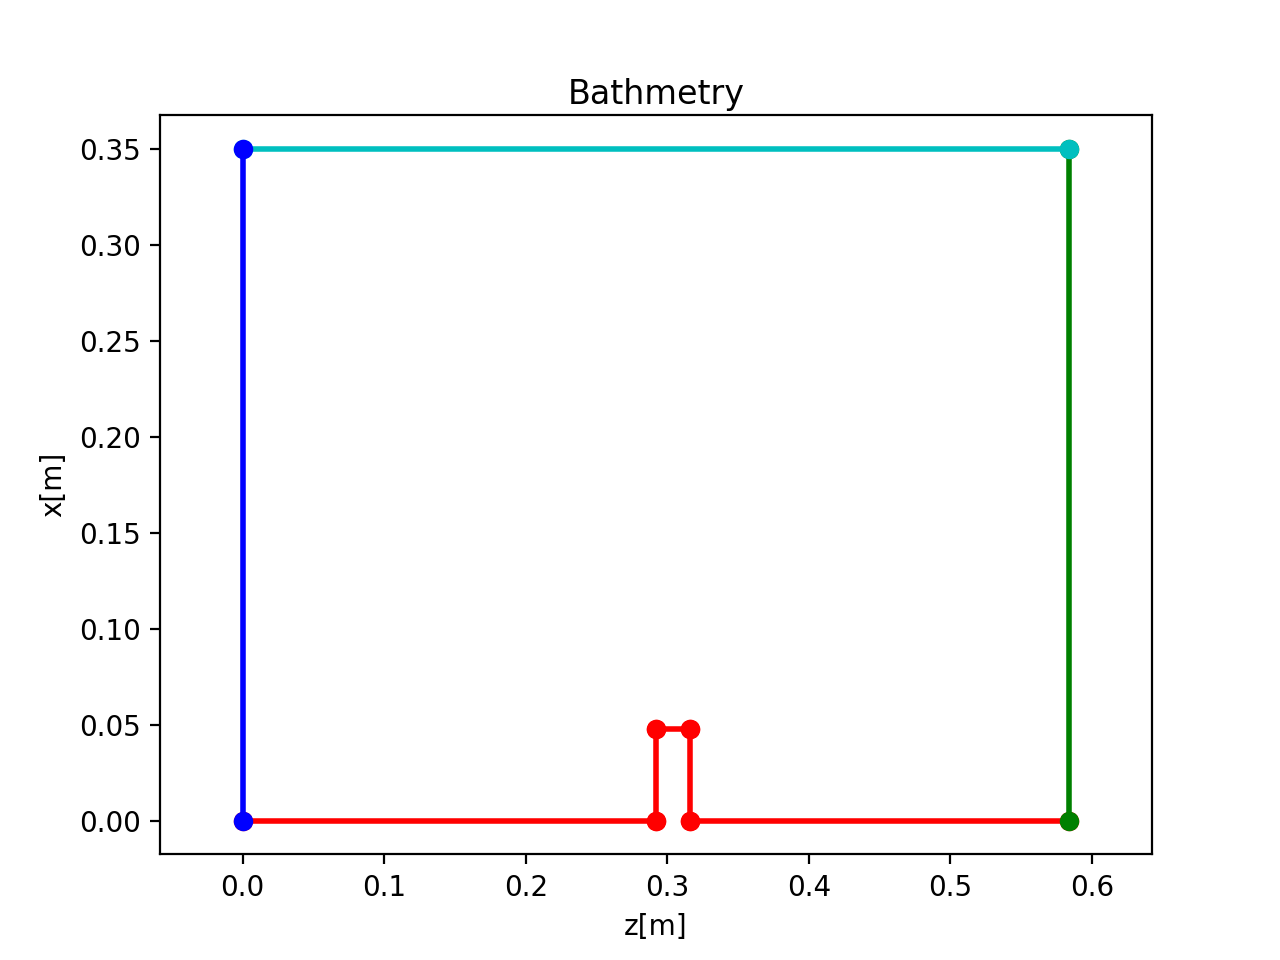

<module 'matplotlib.pyplot' from '/home/cekees/proteus/linux2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [10]:
from helpers import *
plot_domain(view['tank.domain'][0])

# Define the initial free surface

Provide a function that gives the signed distance to the air/water interface

In [11]:
%%px
#def newSignedDistance(x):
#    return (x[0]**2 + x[1]**2)**(0.5) - 0.2
#tank.signedDistance = newSignedDistance

<IPython.core.display.Javascript object>


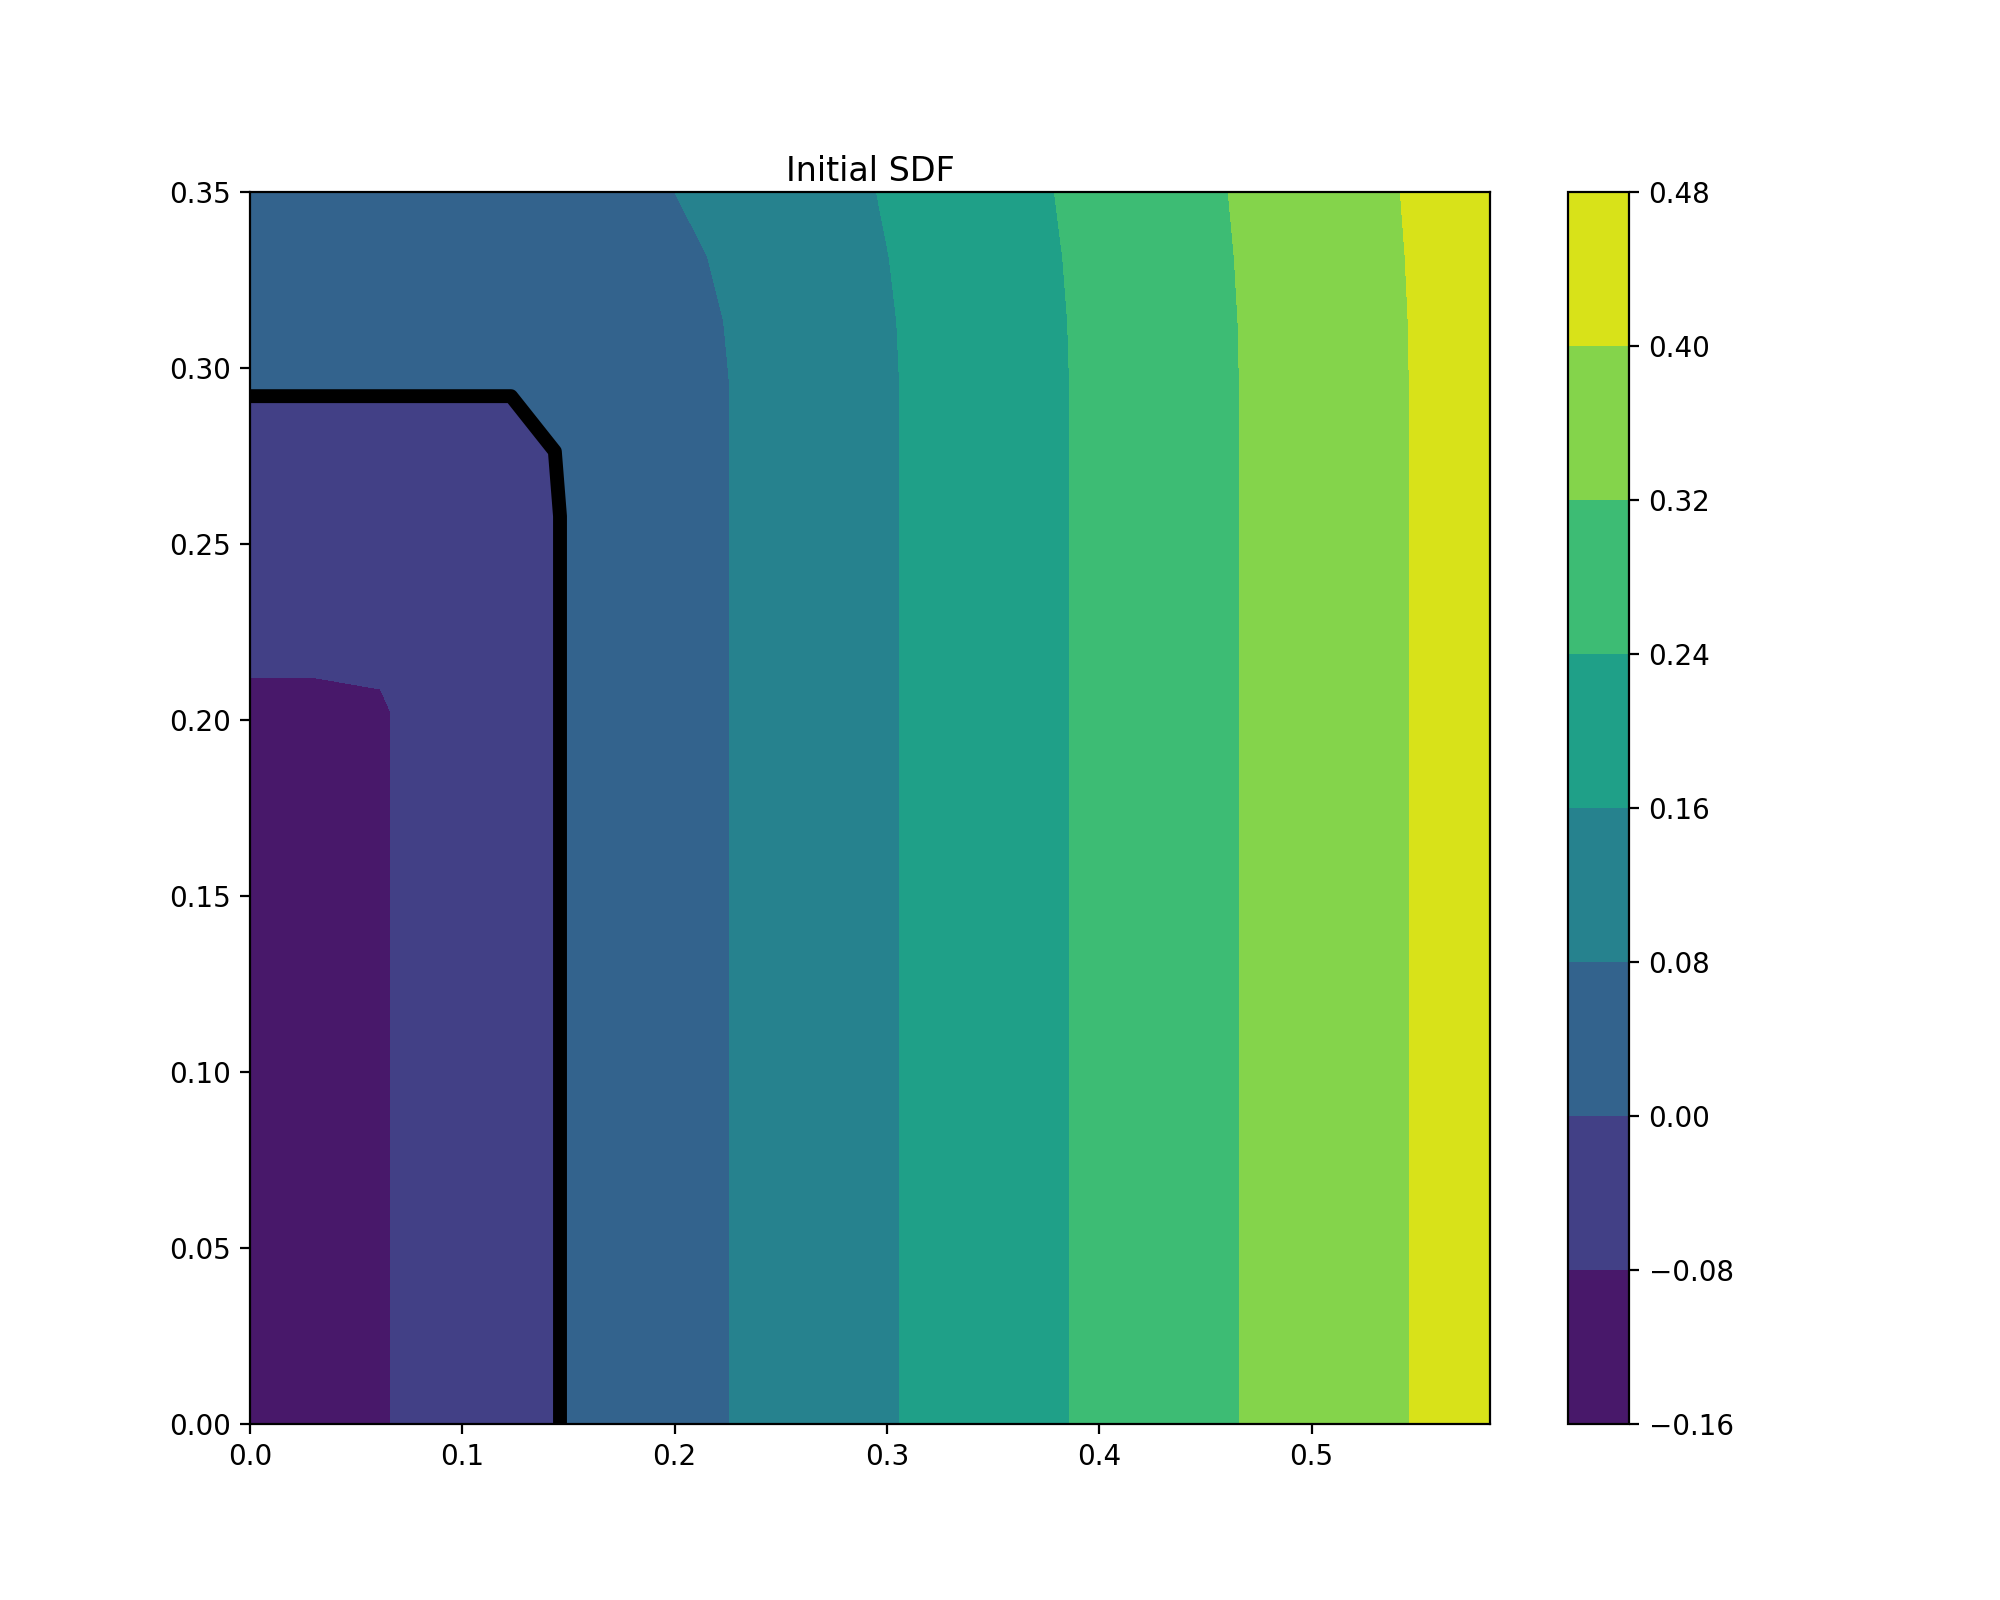

In [12]:
import numpy as np
domain = view['tank.domain'][0]
sdf = view['tank.signedDistance'][0]
xg = np.linspace(0, domain.L[0], 20)
yg = np.linspace(0, domain.L[1], 20)
xi, yi = np.meshgrid(xg,yg)
fig = plt.figure()
phi = np.zeros(xi.shape)
for i in range(20):
    for  j in range(20):
        phi[i,j]  = sdf([xg[j],yg[i]])
plt.contourf(xg,yg,phi)
plt.colorbar()
plt.contour(xg,yg,phi,levels=[0],linewidths=[5], colors='k')
plt.title('Initial SDF')

Physics and Numerics
=================

Load the modules the define the equations to be solved and the numerical methods to use.

In [13]:
%%px
import tank_so
from proteus import Comm
from petsc4py import PETSc

#mesh refinment
tank.he = 0.00621276595745
#tank.he = 0.00310638297872
tank.triangleOptions="VApq30Dena%8.8f" % ((tank.he**2)/2.0,)
#
so = tank_so
so.tnList = so.tnList
pList=[]
nList=[]
so.sList=[]
OptDB = PETSc.Options()
for (p,n) in so.pnList:
    so.sList.append(default_s)
    pList.append(__import__(p))
    reload(pList[-1])
    nList.append(__import__(n))
    reload(nList[-1])
    pList[-1].name = p
    nList[-1].multilevelLinearSolver = default_n.KSP_petsc4py
    nList[-1].levelLinearSolver = default_n.KSP_petsc4py
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"ksp_type", "preonly")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_type", "lu")
    OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_factor_mat_solver_package","superlu_dist")
opts.save_dof = True
opts.dataDir='.'
opts.probDir='.'
opts.logLevel=7
opts.verbose=True

Numerical Solution Object
====================

No we create an the numerical wavetank object and set it up to run in a thread on each engine.

In [14]:
%%px
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)

[stdout:0] TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00001930 
[stdout:1] TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00001930 
[stdout:2] TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00001930 
[stdout:3] TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00001930 


In [15]:
%%px --noblock
from threading import Thread
# Create a thread wrapper for the simulation.  The target must be an argument-less
# function so we wrap the call to `calculateSolution` in a simple lambda:
simulation_thread = Thread(target = lambda : ns.calculateSolution('run1'))

<AsyncResult: execute>

# Some plotting and monitoring utilities

In [16]:
def plot_current_results():
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    import numpy as np
    global nn,x,y,u,triangles
    plt.clf()
    # We make a blocking call to load the remote data from the simulation into simple named 
    # variables we can read from the engine namespaces
    #load_simulation_globals()
    view.apply_sync(load_simulation_globals)
    # And now we can use the view to read these variables from all the engines.  Then we
    # concatenate all of them into single arrays for local plotting
    x = np.concatenate(view['x'])
    y = np.concatenate(view['y'])
    u = np.concatenate(view['u'])
    shifts = np.cumsum([0]+view['nn'][:-1])
    flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(view['triangles'], shifts) ])
    #flat_triangles=triangles
    # We can now call the matplotlib plotting function we need
    plt.tricontourf(x, y, flat_triangles, u)
    fig.canvas.draw()
    return plt

def load_simulation_globals():
    """Put some variables we need in engine namespace.

    These can then be retrieved by clients for inspection, visualization, etc.
    """
    global nn, x, y, u, triangles
    model = ns.modelList[1].levelModelList[-1]
    nodes = model.mesh.nodeArray
    triangles = model.mesh.elementNodesArray
    x = nodes[:,0]
    y = nodes[:,1]
    u = model.u[0].dof_last
    nn = len(x)
    
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    #return simulation_thread.is_alive()
    return any(view.apply_sync(lambda : simulation_thread.is_alive()))

def monitor_simulation(refresh=5.0):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    """
    import datetime as dt, time
    if not simulation_alive():
        plot_current_results(view)
        print 'Simulation has already finished, no monitoring to do.'
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():
            plot_current_results()
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt):#, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    print msg
    print 'Monitored for: %s.' % tmon

Run the tank
==========

In [17]:
%px simulation_thread.start()

<IPython.core.display.Javascript object>


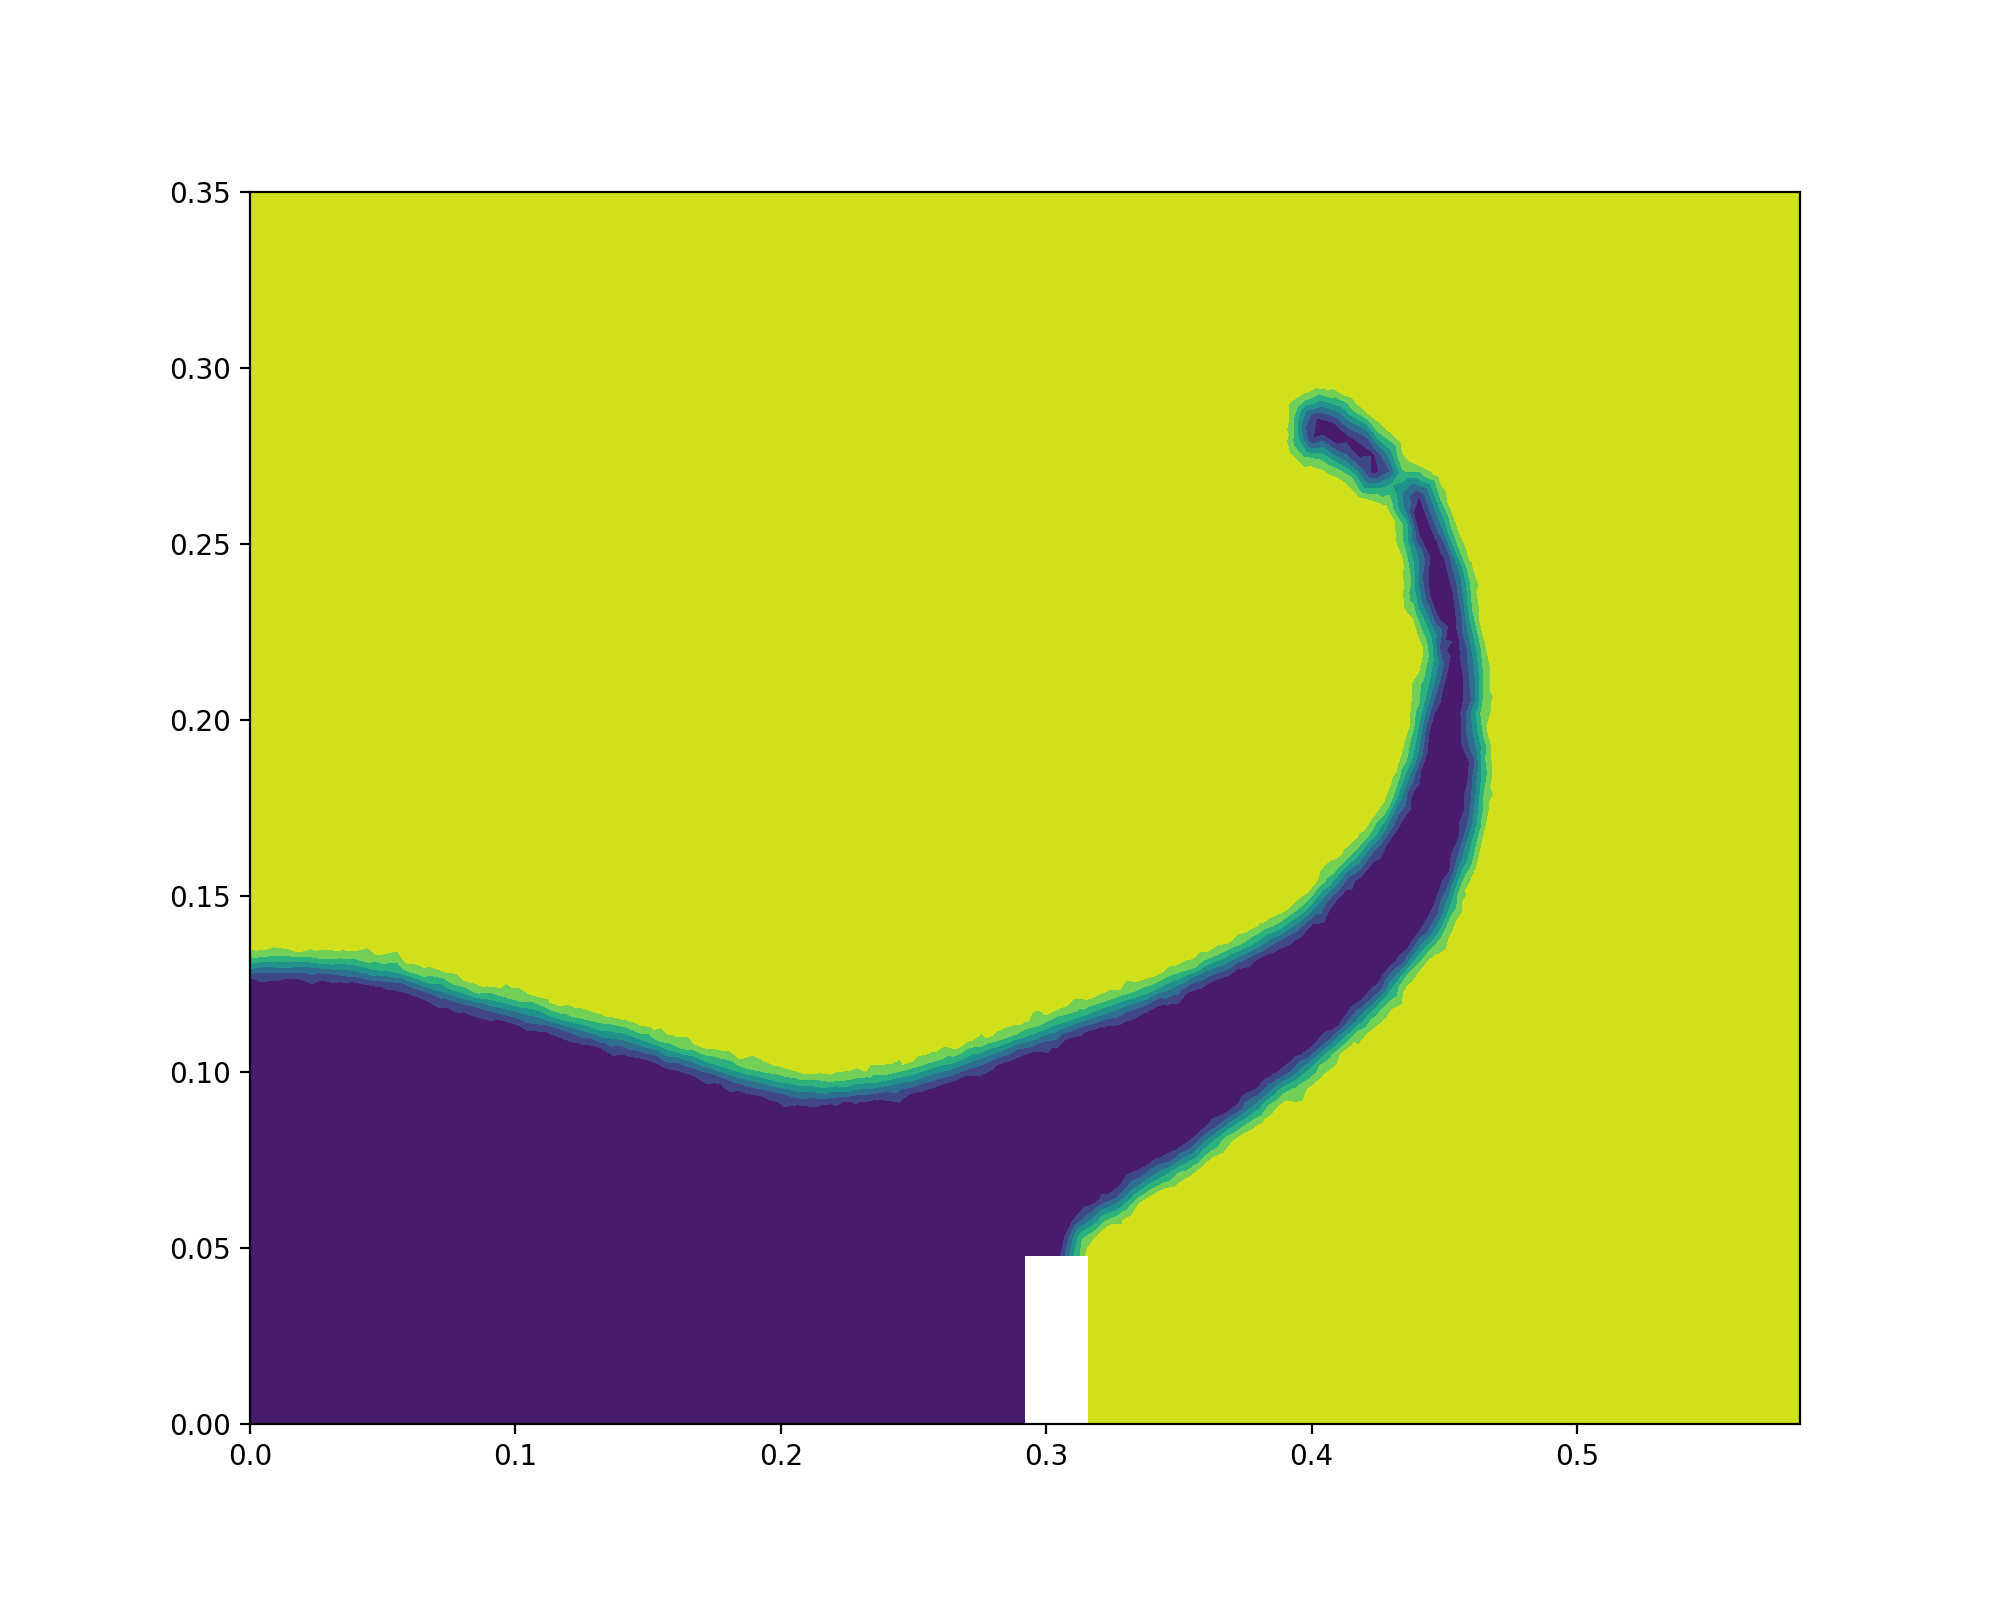

Simulation completed!
Monitored for: 0:04:05.509130.


In [18]:
fig = plt.figure()
monitor_simulation(refresh=5.0)

Post-process the numerical solution
==========================

In [20]:
from tables import  openFile
archive = openFile('tank_p.h5','r')

<IPython.core.display.Javascript object>


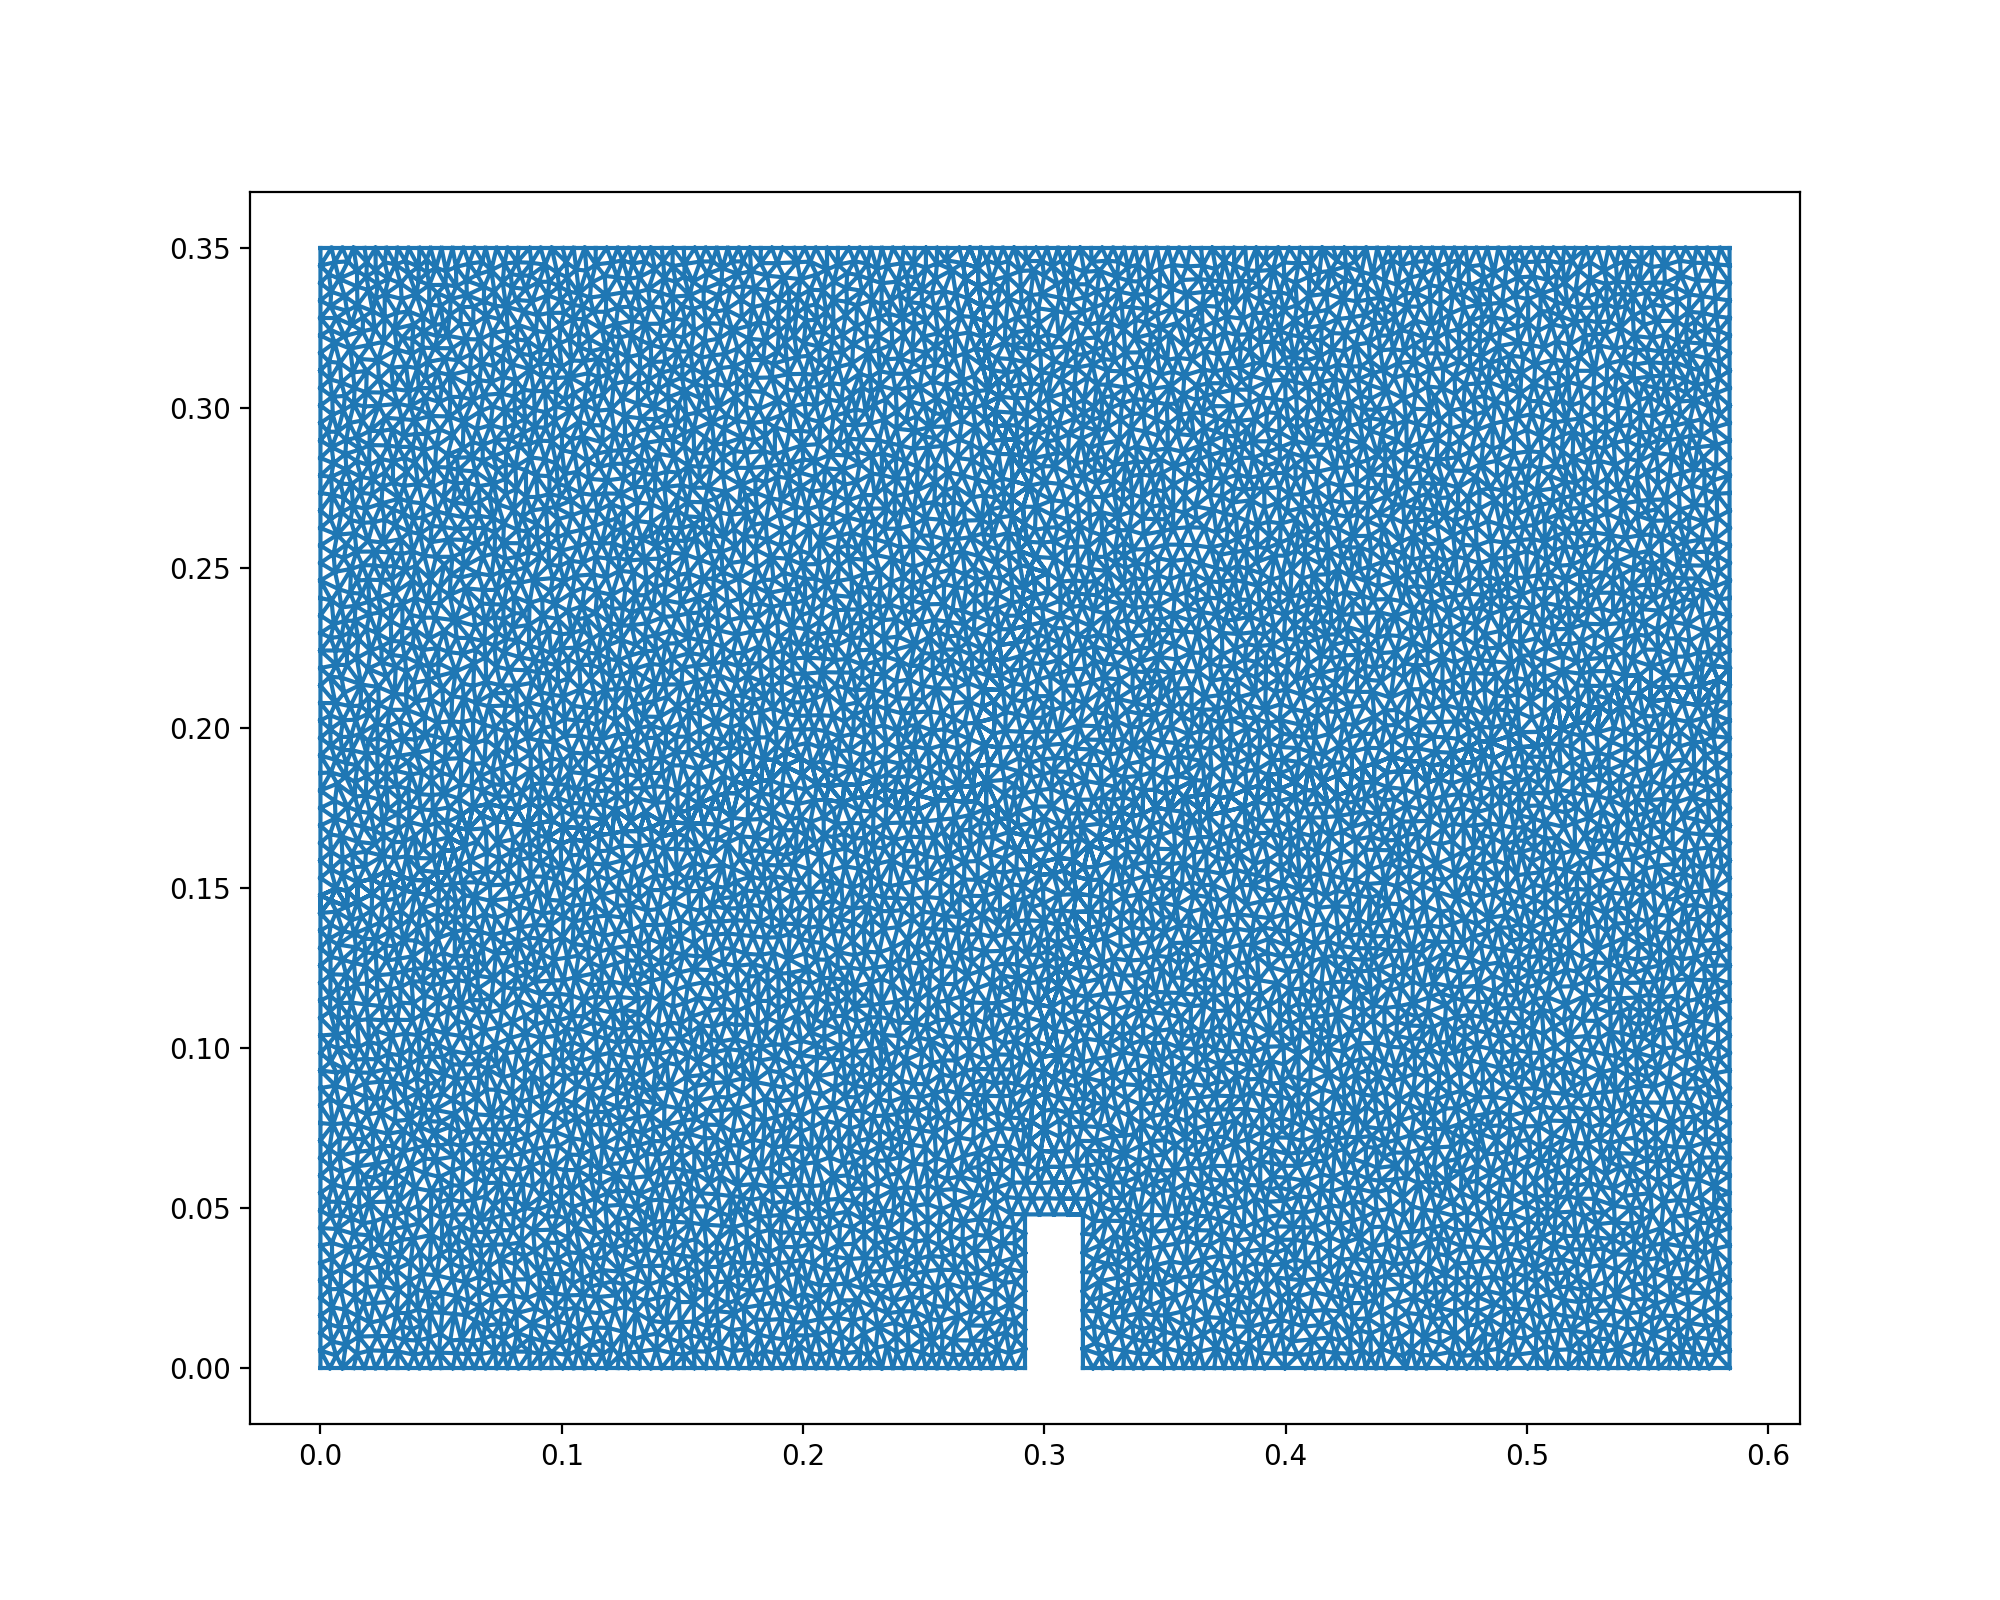

In [21]:
import numpy as  np
x = np.concatenate(view['x'])
y = np.concatenate(view['y'])
shifts = np.cumsum([0]+view['nn'][:-1])
flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(view['triangles'], shifts) ])
plt.figure()
plt.triplot(x,y,flat_triangles)

In [22]:
!rm phi*png

rm: cannot remove 'phi*png': No such file or directory


<IPython.core.display.Javascript object>


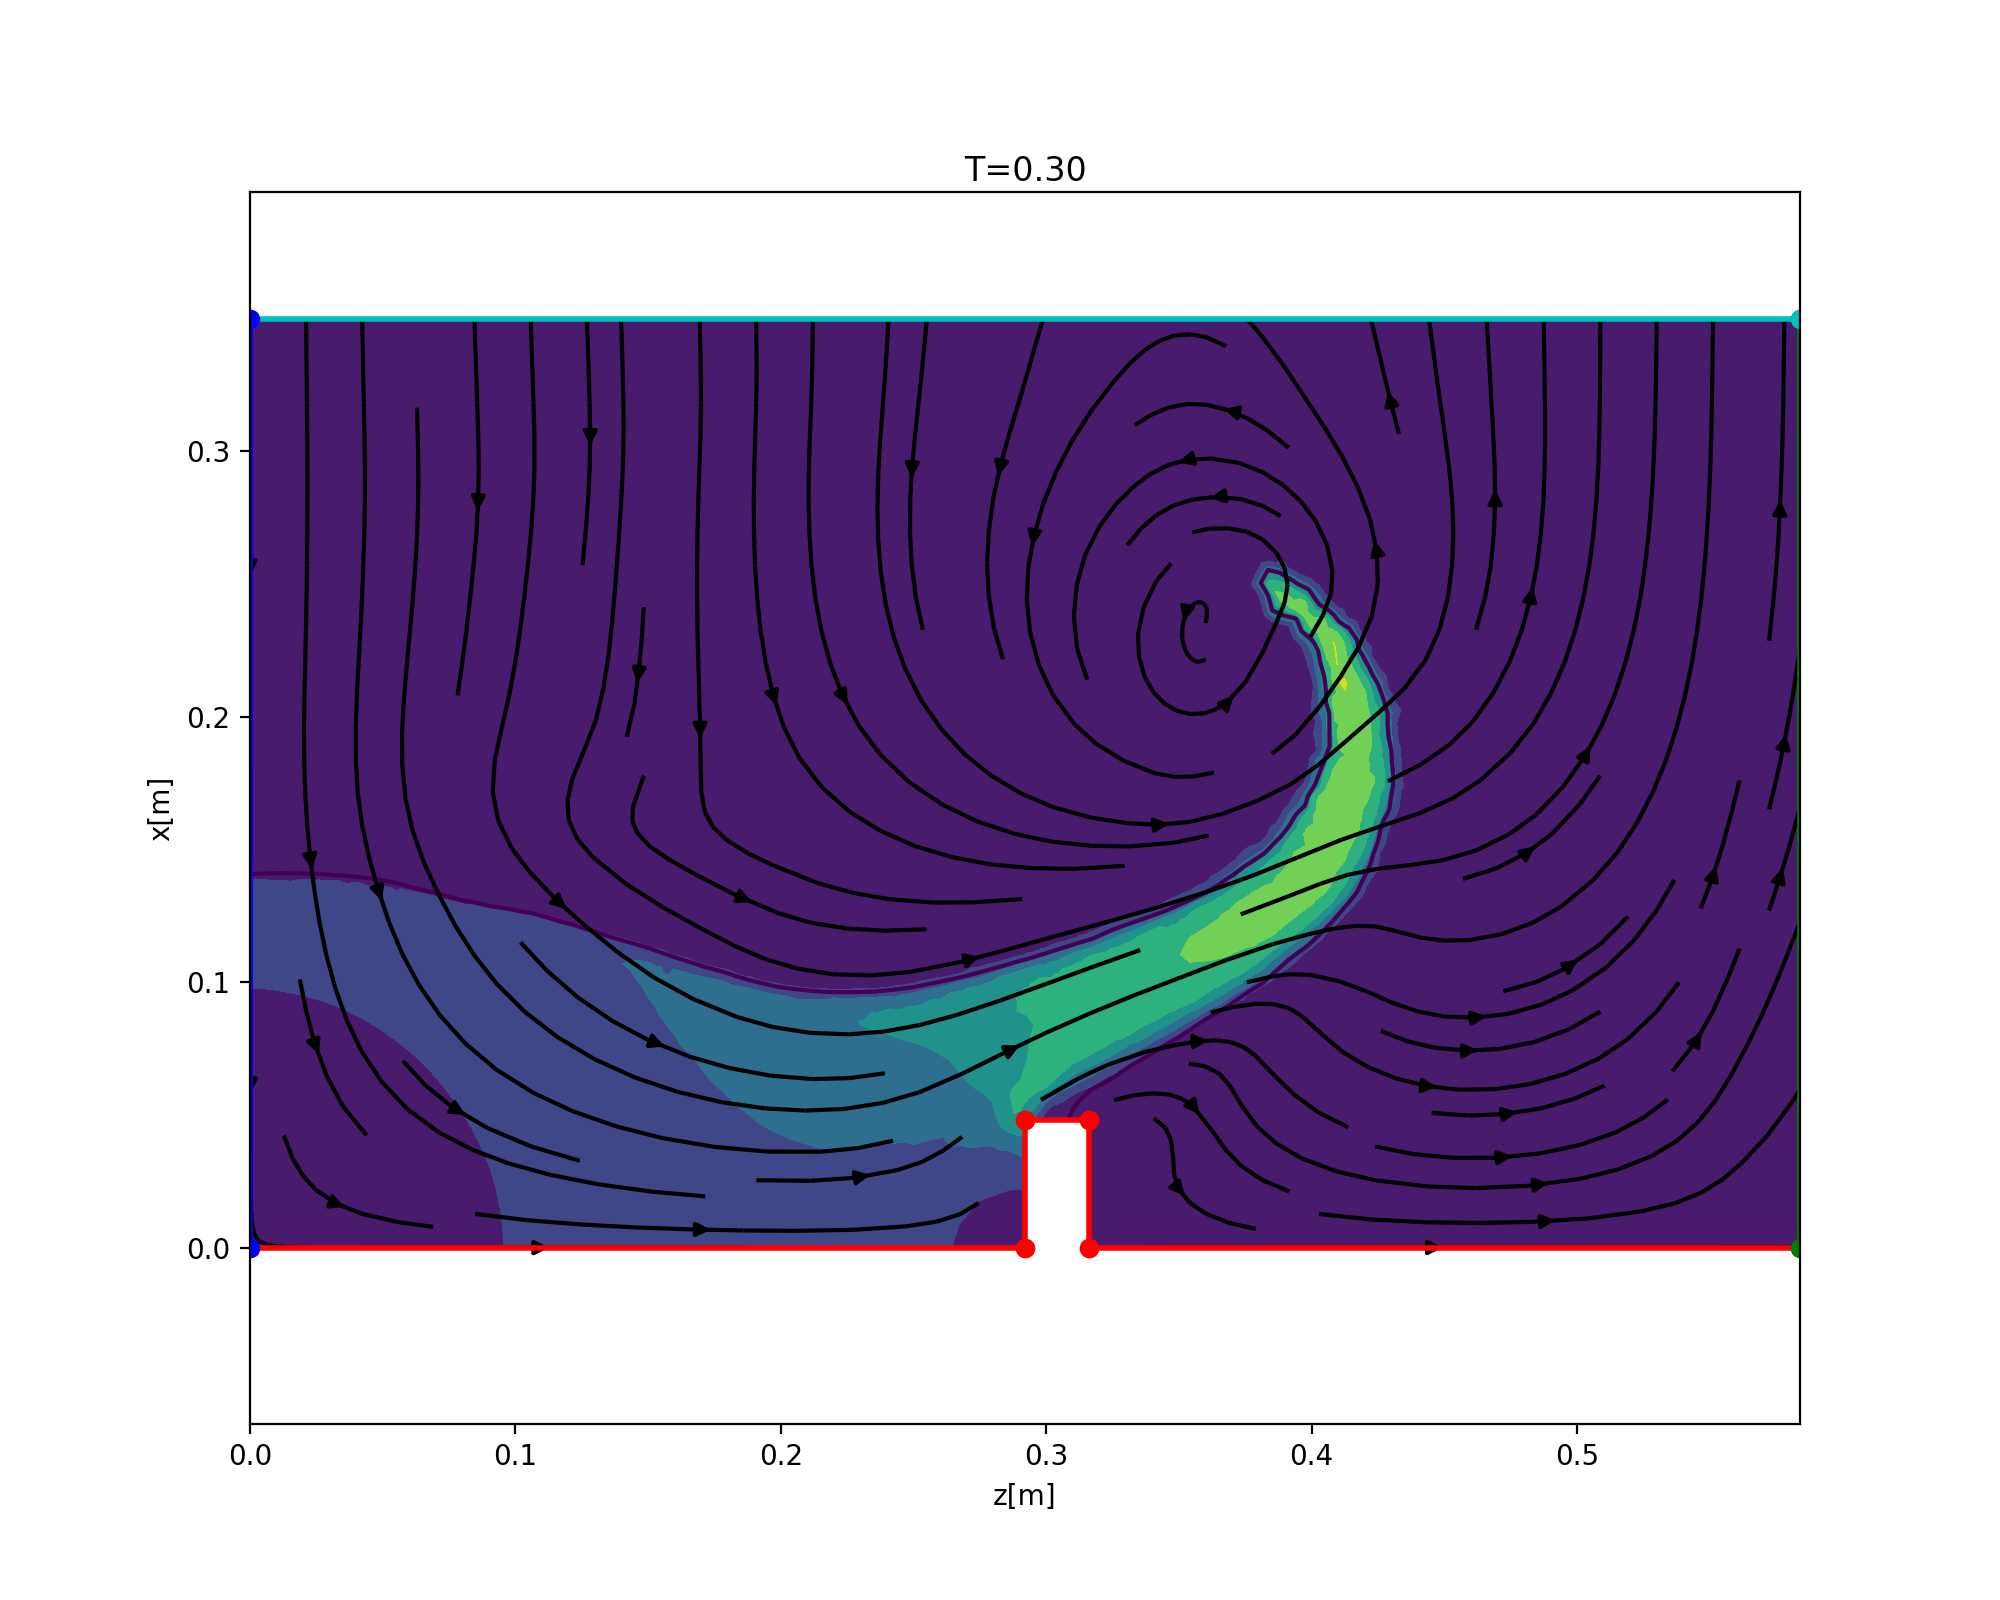

In [23]:
import matplotlib.tri as mtri
domain = view['tank.domain'][0]
nodes = archive.getNode("/nodesSpatial_Domain0")
x=nodes[:,0]
y=nodes[:,1]
elements = archive.getNode("/elementsSpatial_Domain0")
triang = mtri.Triangulation(x, y, elements)
xg = np.linspace(0, domain.L[0], 20)
yg = np.linspace(0, domain.L[1], 20)
xi, yi = np.meshgrid(xg,yg)
plt.figure()
for it,t in enumerate(view['tank_so.tnList'][0][2:]):
    phi = archive.getNode("/phi_t"+`it`)
    vof = archive.getNode("/vof_t"+`it`)
    wvof = np.ones(vof.shape,'d')
    wvof -= vof
    u = archive.getNode("/u_t"+`it`)
    v = archive.getNode("/v_t"+`it`)
    plt.clf()
    plt.xlabel(r'z[m]')
    plt.ylabel(r'x[m]')
    colors = ['b','g','r','c','m','y','k','w']
    plt.xlim(domain.x[0]-0.1*domain.L[0],domain.x[0]+domain.L[0]+0.1*domain.L[0])    
    for si,s in enumerate(domain.segments):
        plt.plot([domain.vertices[s[0]][0],
                     domain.vertices[s[1]][0]],
                    [domain.vertices[s[0]][1],
                     domain.vertices[s[1]][1]],
                    color=colors[domain.segmentFlags[si]-1],
                    linewidth=2,
                    marker='o')
    plt.tricontourf(x,y,elements,wvof*np.sqrt(u[:]**2 + v[:]**2))
    plt.tricontour(x,y,elements,phi,[0], linewidth=4)
    u_interp_lin = mtri.LinearTriInterpolator(triang, u[:])
    v_interp_lin = mtri.LinearTriInterpolator(triang, v[:])
    u_lin = u_interp_lin(xi, yi)
    v_lin = v_interp_lin(xi, yi)
    plt.streamplot(xg, yg, u_lin, v_lin,color='k')
    plt.title('T=%2.2f' % (t,))
    plt.axis('equal')
    plt.xlim((0,domain.L[0]))
    plt.savefig('phi%4.4d.png' % (it,))

In [24]:
!rm tankPhi.mp4; ffmpeg -i phi%4d.png -vcodec libx264 tankPhi.mp4

rm: cannot remove 'tankPhi.mp4': No such file or directory
ffmpeg version 3.0.5-0ubuntu0.16.10.1 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 6.2.0 (Ubuntu 6.2.0-5ubuntu12) 20161005
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.10.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librubberband --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enabl

In [25]:
from IPython.core.display import HTML
data_uri_mp4 = open("tankPhi.mp4", "rb").read().encode("base64").replace("\n", "")
video_tag = """<video controls>
<source type ="video/mp4" src="data:video/mp4;base64,{mp4}"/>
Your browser does not support the video tag
</video>""".format(mp4=data_uri_mp4)
HTML(data=video_tag)

In [26]:
from IPython.display import FileLink,FileLinks
FileLink('tankPhi.mp4')

/home/cekees/proteus/notebooks/Applications/wavetank2d/tankPhi.mp4